# Puget Sound Plotting2

In [1]:
import erddapy
from erddapy import ERDDAP
import numpy as np
import pandas as pd
import xarray
import cf_xarray
import datetime
import netCDF4
from netCDF4 import Dataset

import matplotlib
from matplotlib import pyplot as plt

In [2]:
def get_erddap_data(erddap_url, dataset, data_protocol="griddap", variables=None, constraints=None):
    """
    Function: get_erddap_data
    This function uses the erddapy python library to access data from ERDDAP servers,
    and to return it to users in convenient formats for python users.
    Data can be pulled from "tabledap" or "griddap" formats, with different
    output types, depending on the dap type.
    
    Inputs:
    erddap_url    - The url address of the erddap server to pull data from
    variables     - The selected variables within the dataset.
    data_protocol - The erddap data protocol for the chosen dataset.
                    Options include "tabledap" or "griddap"
                    The default option is given as "griddap"
    dataset       - The ID for the relevant dataset on the erddap server
                    If no variables are given, it is assumed that all variables
                    will be pulled.
    constraints   - These are set by the user to help restrict the data pull
                    to only the area and timeframe of interest.
                    If no constraints are given, all data in a dataset is pulled.
                    Constraints should be given as a dictionary, where
                    each entry is a bound and/or selection of a specific axis variable
                    Exs. {"longitude<=": "min(longitude)+10", "longitude>=": "0"}
                         {"longitude=": "140", "time>=": "max(time)-30"}
    
    Outputs:
    erddap_data   - This variable contains the pulled data from the erddap server.
                    If the data_protocol is "griddap",  then erddap_data is an xarray dataset
                    If the data_protocol is "tabledap", then erddap_data is a pandas dataframe
    """
    
    import erddapy
    from erddapy import ERDDAP
    import pandas as pd
    import xarray
    
    
    ############################################
    # Set-up the connection to the ERDDAP server
    ############################################
    
    # Connect to the erddap server
    e = ERDDAP(server=erddap_url, protocol=data_protocol, response='csv')
    
    # Identify the dataset of interest
    e.dataset_id = dataset
    
    
    #########################################
    # Pull the data, based upon protocol type
    #########################################
    
    # GRIDDAP Protocol
    if data_protocol == "griddap":
        
        # Initialize the connection
        e.griddap_initialize()

        # Update the constraints
        if constraints is not None:
            e.constraints.update(constraints)
            e.griddap_initialize()
            
        # Update the selection of the variables
        if variables is not None:
            e.variables = variables

        erddap_data = e.to_xarray()
    
    # TABLEDAP Protocol
    elif data_protocol == "tabledap":

        # Update the constraints
        if constraints is not None:
            e.constraints = constraints
            
        # Update the selection of the variables
        if variables is not None:
            e.variables = variables
            
        erddap_data = e.to_pandas()
    
    # Invalid protocol given
    else:
        print('Invalid ERDDAP protocol. Given protocol is: ' + data_protocol)
        print('Valid protocols include "griddap" or "tabledap". Please restart and try again with a valid protocol')
        erddap_data = None
    
    
    #############################
    return erddap_data

In [3]:
nwem_url = 'http://nwem.apl.washington.edu/erddap'

nwem_dataset1 = 'orca3_L3_depthgridded_025'
nwem_dataset2 = 'npby1_L3_depthgridded_025'

variables = ["sea_water_temperature",
             "sea_water_practical_salinity","mass_concentration_of_oxygen_in_sea_water","sea_water_temperature_qc_agg",
             "sea_water_practical_salinity_qc_agg","mass_concentration_of_oxygen_in_sea_water_qc_agg"]

constraints = {"cast_start_time>=":datetime.datetime(2012,1,1).strftime('%Y-%m-%dT%H:%M:%SZ')}
#constraints = {"cast_start_time>=": "max(cast_start_time)-365"}

nwem_grid1 = get_erddap_data(nwem_url, nwem_dataset1, 
                variables=variables, 
                constraints=constraints,
                data_protocol="griddap")

nwem_grid2 = get_erddap_data(nwem_url, nwem_dataset2, 
                variables=variables, 
                constraints=constraints,
                data_protocol="griddap")

In [4]:
ds1=nwem_grid1; ds2=nwem_grid2; 

In [5]:
depth1=np.array(ds1.depth.values[:]); depth2=np.array(ds2.depth.values[:]); 
date1=np.array(ds1.cast_start_time.values[:]); date2=np.array(ds2.cast_start_time.values[:])#325
depth_l="50"

In [6]:
str1="sea_water_temperature"; str2="sea_water_practical_salinity";str3='mass_concentration_of_oxygen_in_sea_water';
str4="sea_water_temperature_qc_agg"; str5="sea_water_practical_salinity_qc_agg";str6='mass_concentration_of_oxygen_in_sea_water_qc_agg';

In [7]:
var1_sst=ds1[str1]; var1_sss=ds1[str2]; var1_oxy=ds1[str3]; var1_sstqc=ds1[str4]; var1_sssqc=ds1[str5]; var1_oxyqc=ds1[str6]; ## Accessing buoy1
var1_sst=var1_sst.where(var1_sstqc == 1); var1_sss=var1_sss.where(var1_sssqc == 1); var1_oxy=var1_oxy.where(var1_oxyqc == 1) ## Extracting only good data 

var2_sst=ds2[str1]; var2_sss=ds2[str2]; var2_oxy=ds2[str3]; var2_sstqc=ds2[str4]; var2_sssqc=ds2[str5]; var2_oxyqc=ds2[str6]## Accessing buoy2
var2_sst=var2_sst.where(var2_sstqc==1); var2_sss=var2_sss.where(var2_sssqc==1); var2_oxy=var2_oxy.where(var2_oxyqc==1); 

In [8]:
var1_sst=var1_sst.assign_coords(time=("cast_start_time",date1))
var1_sss=var1_sss.assign_coords(time=("cast_start_time",date1))
var1_oxy=var1_oxy.assign_coords(time=("cast_start_time",date1))

var2_sst=var2_sst.assign_coords(time=("cast_start_time",date2))
var2_sss=var2_sss.assign_coords(time=("cast_start_time",date2))
var2_oxy=var2_oxy.assign_coords(time=("cast_start_time",date2))

In [9]:
sst1=var1_sst.transpose(); sst2=var2_sst.transpose();
sss1=var1_sss.transpose(); sss2=var2_sss.transpose();
oxy1=var1_oxy.transpose(); oxy2=var2_oxy.transpose();

In [10]:
formatted_time = np.datetime_as_string(date1, unit='D')
tick_positions = np.linspace(0, len(date1) - 1, 6, dtype=int)
tick_labels = [formatted_time[i] for i in tick_positions]

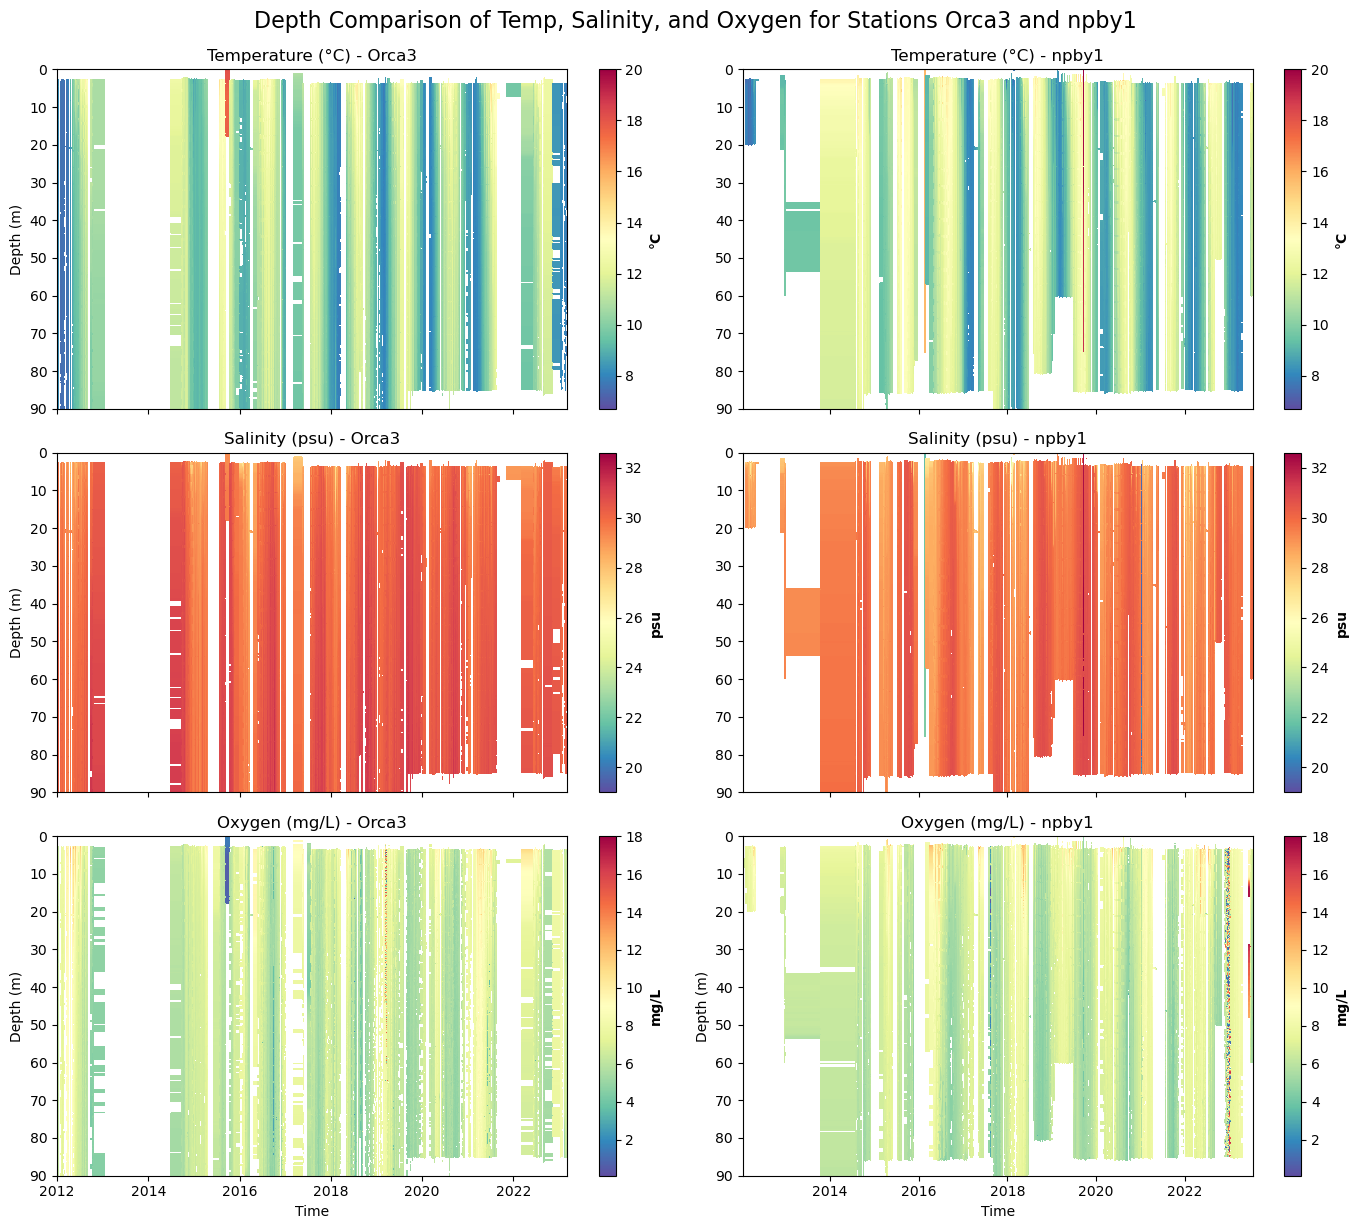

In [11]:
f, axes = plt.subplots(3, 2, figsize=(14, 12))  # 3 rows, 2 columns

# Plot Temperature subplots
sc1_1 = axes[0, 0].pcolor(date1, depth1, sst1, cmap="Spectral_r", vmin=6.7,vmax=20)
axes[0, 0].set_title("Temperature (°C) - Orca3")
axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("Depth (m)")
axes[0, 0].invert_yaxis()  # Invert y axis
axes[0, 0].set_xticklabels([])
axes[0, 0].set_ylim([90, 0])  # Set y-axis range
#axes[0, 0].set_clim([10, 22])

sc1_2 = axes[0, 1].pcolor(date2, depth2, sst2, cmap="Spectral_r", vmin=6.7,vmax=20)
axes[0, 1].set_title("Temperature (°C) - npby1")
axes[0, 1].set_xlabel("")
#axes[0, 1].set_ylabel("Depth (m)")
axes[0, 1].invert_yaxis()  # Invert y axis
axes[0, 1].set_xticklabels([])
axes[0, 1].set_ylim([90, 0])  # Set y-axis range

# Plot Salinity subplots
sc2_1 = axes[1, 0].pcolor(date1, depth1, sss1, cmap="Spectral_r", vmin=19,vmax=32.6)
axes[1, 0].set_title("Salinity (psu) - Orca3")
axes[1, 0].set_xlabel("")
axes[1, 0].set_ylabel("Depth (m)")
axes[1, 0].invert_yaxis()  # Invert y axis
axes[1, 0].set_xticklabels([])
axes[1, 0].set_ylim([90, 0])  # Set y-axis range

sc2_2 = axes[1, 1].pcolor(date2, depth2, sss2, cmap="Spectral_r", vmin=19,vmax=32.6)
axes[1, 1].set_title("Salinity (psu) - npby1")
axes[1, 1].set_xlabel("")
#axes[1, 1].set_ylabel("Depth (m)")
axes[1, 1].invert_yaxis()  # Invert y axis
axes[1, 1].set_xticklabels([])
axes[1, 1].set_ylim([90, 0])  # Set y-axis range

# Plot Oxygen subplots
sc3_1 = axes[2, 0].pcolor(date1, depth1, oxy1, cmap="Spectral_r",vmin=0.1,vmax=18)
axes[2, 0].set_title("Oxygen (mg/L) - Orca3")
axes[2, 0].set_ylabel("Depth (m)")
axes[2, 0].set_xlabel("Time")
axes[2, 0].invert_yaxis()  # Invert y axis
axes[2, 0].set_ylim([90, 0])  # Set y-axis range

sc3_2 = axes[2, 1].pcolor(date2, depth2, oxy2, cmap="Spectral_r",vmin=0.1,vmax=18)
axes[2, 1].set_title("Oxygen (mg/L) - npby1")
axes[2, 1].set_ylabel("Depth (m)")
axes[2, 1].set_xlabel("Time")
axes[2, 1].invert_yaxis()  # Invert y axis
axes[2, 1].set_ylim([90, 0])  # Set y-axis range

# Add colorbars
cbar1_1 = f.colorbar(sc1_1, ax=axes[0, 0], orientation='vertical')
cbar1_1.ax.set_ylabel('°C', fontweight='bold')
cbar1_1.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight

cbar1_2 = f.colorbar(sc1_2, ax=axes[0, 1], orientation='vertical')
cbar1_2.ax.set_ylabel('°C', fontweight='bold')
cbar1_2.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight

cbar2_1 = f.colorbar(sc2_1, ax=axes[1, 0], orientation='vertical')
cbar2_1.ax.set_ylabel('psu', fontweight='bold')
cbar2_1.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight

cbar2_2 = f.colorbar(sc2_2, ax=axes[1, 1], orientation='vertical')
cbar2_2.ax.set_ylabel('psu', fontweight='bold')
cbar2_2.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight

cbar3_1 = f.colorbar(sc3_1, ax=axes[2, 0], orientation='vertical')
cbar3_1.ax.set_ylabel('mg/L', fontweight='bold')
cbar3_1.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight

cbar3_2 = f.colorbar(sc3_2, ax=axes[2, 1], orientation='vertical')
cbar3_2.ax.set_ylabel('mg/L', fontweight='bold')
cbar3_2.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight

# Adjust layout
plt.tight_layout()
f.suptitle("Depth Comparison of Temp, Salinity, and Oxygen for Stations Orca3 and npby1", fontsize=16, y=1.02)
plt.show()